# UMAP

In [1]:
import pandas as pd
import numpy as np
from pyspark.sql import *
from pyspark.sql.functions import *
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import seaborn as sns
import time

## Load MNIST dataset

In [2]:
"""
Load and return OpenML's MNIST database of handwritten digits with 70,000 examples and 784 features across 10 classes.
Loads the data into a pandas DataFrame with default datatype float64.
"""

mnist = fetch_openml("mnist_784", version=1, parser='auto')
print(mnist.data.shape)
mnist.data.info(memory_usage='deep')

(70000, 784)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Columns: 784 entries, pixel1 to pixel784
dtypes: int64(784)
memory usage: 418.7 MB


## Convert dataset to Spark DataFrame

#### Create Spark Session
UMAP is a driver-intensive algorithm. Be sure to allocate enough resources for the driver in the Spark config.

In [3]:
_config = {
    "spark.master": f"local[3]",
    "spark.python.worker.reuse": "false",
    "spark.driver.host": "127.0.0.1",
    "spark.task.maxFailures": "1",
    # allocate enough driver memory and set maxResultSize to avoid OOM during serialization
    "spark.driver.memory": "15g",
    "spark.driver.maxResultSize": "0",
    "spark.sql.execution.pyspark.udf.simplifiedTraceback.enabled": "false",
    "spark.sql.pyspark.jvmStacktrace.enabled": "true",
    "spark.sql.execution.arrow.pyspark.enabled": "true",
}
spark = SparkSession.builder.appName("spark-rapids-ml umap")
for key, value in _config.items():
    spark = spark.config(key, value)
spark = spark.getOrCreate()

23/08/01 11:25:23 WARN Utils: Your hostname, 728fbda-lcedt resolves to a loopback address: 127.0.1.1; using 10.110.44.254 instead (on interface enp1s0)
23/08/01 11:25:23 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/01 11:25:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


#### Convert dataset to Spark DataFrame

In [4]:
df = spark.createDataFrame(mnist.data)
df.printSchema()

root
 |-- pixel1: long (nullable = true)
 |-- pixel2: long (nullable = true)
 |-- pixel3: long (nullable = true)
 |-- pixel4: long (nullable = true)
 |-- pixel5: long (nullable = true)
 |-- pixel6: long (nullable = true)
 |-- pixel7: long (nullable = true)
 |-- pixel8: long (nullable = true)
 |-- pixel9: long (nullable = true)
 |-- pixel10: long (nullable = true)
 |-- pixel11: long (nullable = true)
 |-- pixel12: long (nullable = true)
 |-- pixel13: long (nullable = true)
 |-- pixel14: long (nullable = true)
 |-- pixel15: long (nullable = true)
 |-- pixel16: long (nullable = true)
 |-- pixel17: long (nullable = true)
 |-- pixel18: long (nullable = true)
 |-- pixel19: long (nullable = true)
 |-- pixel20: long (nullable = true)
 |-- pixel21: long (nullable = true)
 |-- pixel22: long (nullable = true)
 |-- pixel23: long (nullable = true)
 |-- pixel24: long (nullable = true)
 |-- pixel25: long (nullable = true)
 |-- pixel26: long (nullable = true)
 |-- pixel27: long (nullable = true)
 |-- 

## Spark RAPIDS ML (GPU)

In [6]:
from spark_rapids_ml.umap import UMAP

In [7]:
feature_cols = [f"pixel{i}" for i in range(1, mnist.data.shape[1] + 1)]
umap_estimator = UMAP(num_workers=3).setFeaturesCols(feature_cols)

### Fit
Note that fit is executed on a single node, as multi-node fitting is not yet supported.

In [9]:
start_time = time.time()
umap_model = umap_estimator.fit(df)
print(f"total time: {time.time() - start_time} sec")

23/08/01 11:28:00 WARN TaskSetManager: Stage 1 contains a task of very large size (61294 KiB). The maximum recommended task size is 1000 KiB.
23/08/01 11:28:05 WARN TaskSetManager: Stage 2 contains a task of very large size (61294 KiB). The maximum recommended task size is 1000 KiB.
2023-08-01 11:28:07,926 - spark_rapids_ml.umap.UMAP - INFO - Initializing cuml context
2023-08-01 11:28:09,640 - spark_rapids_ml.umap.UMAP - INFO - Loading data into python worker memory
2023-08-01 11:28:11,957 - spark_rapids_ml.umap.UMAP - INFO - Invoking cuml fit
2023-08-01 11:28:11,957 - spark_rapids_ml.umap.UMAP - INFO - Cuml fit complete


total time: 28.82920551300049 sec


#### Saving and loading
The UMAP estimator and model can be persisted using the PySpark save() API. Below is an example of saving and loading the model after fitting. The trained embeddings are retained. 

In [10]:
model_path = "/tmp/umap-model"
umap_model.write().overwrite().save(model_path)
umap_model_loaded = umap_model.load(model_path)
print("Model embedding shape:", len(umap_model_loaded.embedding), ",", len(umap_model_loaded.embedding[0]))

23/08/01 11:28:41 WARN TaskSetManager: Stage 6 contains a task of very large size (288497 KiB). The maximum recommended task size is 1000 KiB.


Model embedding shape: 70000 , 2


### Transform

In [11]:
start_time = time.time()
df_output = umap_model.transform(df)
df_output.cache()
df_output.count()
print(f"Transform took: {time.time() - start_time} sec")

23/08/01 11:29:21 WARN TaskSetManager: Stage 9 contains a task of very large size (61294 KiB). The maximum recommended task size is 1000 KiB.


Transform took: 54.24981737136841 sec


#### Visualize embeddings
Notice that UMAP groups individual digit classes while retaining the global structure among different digit classes. 
Groups of digits that may blend together, such as (4, 9) and (3, 5, 8) are embedded near each other, while distinct digits such as (0, 1) are placed far from each other.

23/08/01 11:32:05 WARN TaskSetManager: Stage 13 contains a task of very large size (61294 KiB). The maximum recommended task size is 1000 KiB.


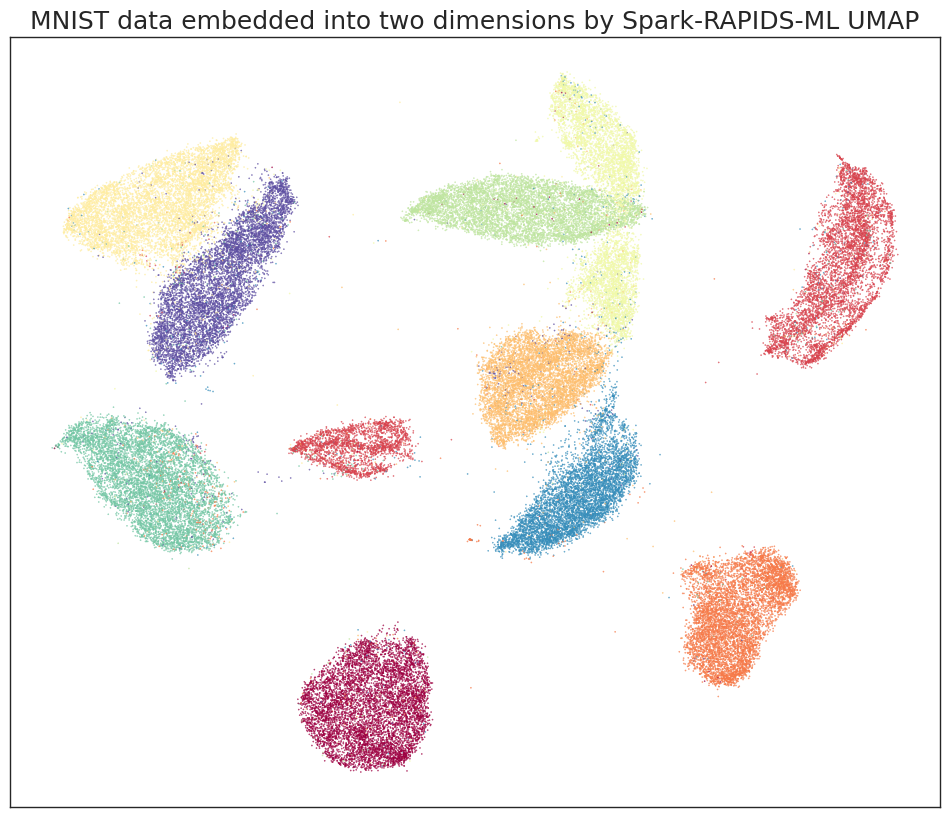

/tmp/ipykernel_1115664/4225546272.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("Spectral", 10)


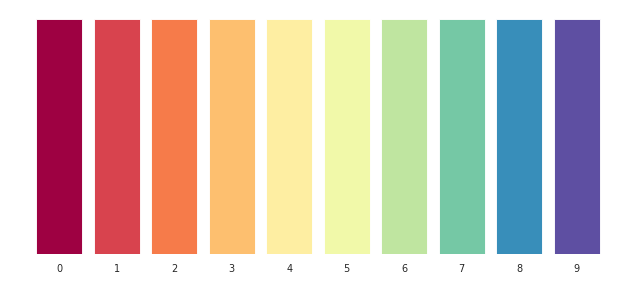

In [13]:
pd_output = df_output.toPandas()
embedding = np.array(pd_output["embedding"].to_list())

# Plot the transformed embeddings
sns.set(context="paper", style="white")
fig, ax = plt.subplots(figsize=(12, 10))
color = mnist.target.astype(int)
plt.scatter(embedding[:, 0], embedding[:, 1], c=color, cmap="Spectral", s=0.1)
plt.setp(ax, xticks=[], yticks=[])
plt.title("MNIST data embedded into two dimensions by Spark-RAPIDS-ML UMAP", fontsize=18)
plt.show()

# Plot the digit colors
cmap = plt.cm.get_cmap("Spectral", 10)
fig, ax = plt.subplots(1, 1, figsize=(10, 4),
                        dpi=80, facecolor='w', edgecolor='k')
for sp in ax.spines.values():
    sp.set_visible(False)
bars = ax.bar(np.arange(10), [1]*10, color=[cmap(i/9) for i in range(10)])
plt.xticks(np.arange(10), np.arange(10))
ax.set_yticks([])
plt.show()

## UMAP (Local, CPU)

In [14]:
%pip install umap-learn
import umap as local_umap

Note: you may need to restart the kernel to use updated packages.


/home/rishic/anaconda3/envs/rapids-23.06/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/rishic/anaconda3/envs/rapids-23.06/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/rishic/anaconda3/envs/rapids-23.06/lib/python3.9/site-

In [15]:
local_umap = local_umap.UMAP()

### Fit + Transform

In [16]:
start_time = time.time()
local_umap.fit(mnist.data)
print(f"Fit took: {time.time() - start_time} sec")

Fit took: 33.81636357307434 sec


In [17]:
start_time = time.time()
embedding = local_umap.transform(mnist.data)
print(f"Transform took: {time.time() - start_time} sec")

Transform took: 0.39460277557373047 sec


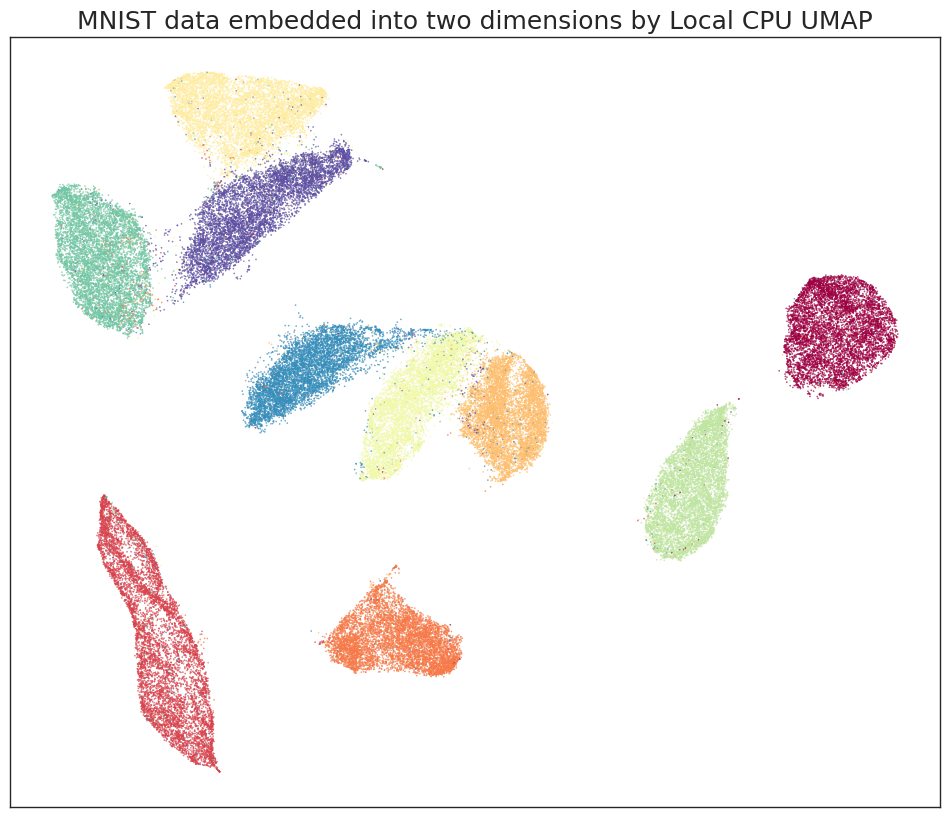

/tmp/ipykernel_1115664/1413413876.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("Spectral", 10)


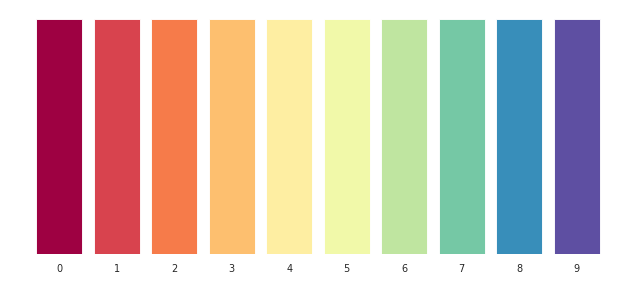

In [18]:
fig, ax = plt.subplots(figsize=(12, 10))
color = mnist.target.astype(int)
plt.scatter(embedding[:, 0], embedding[:, 1], c=color, cmap="Spectral", s=0.1)
plt.setp(ax, xticks=[], yticks=[])
plt.title("MNIST data embedded into two dimensions by Local CPU UMAP", fontsize=18)
plt.show()

# Plot the digit colors
cmap = plt.cm.get_cmap("Spectral", 10)
fig, ax = plt.subplots(1, 1, figsize=(10, 4),
                        dpi=80, facecolor='w', edgecolor='k')
for sp in ax.spines.values():
    sp.set_visible(False)
bars = ax.bar(np.arange(10), [1]*10, color=[cmap(i/9) for i in range(10)])
plt.xticks(np.arange(10), np.arange(10))
ax.set_yticks([])
plt.show()